In [32]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

#### Movimiento browniano geométrico. Delta y gamma + FD 

In [33]:
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    
   # K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    
    if CP == 'call':
        value = norm.cdf(d1) * S_0 - norm.cdf(d2) * K * np.exp(-r * (T-t))

    elif CP == 'put':
        value = norm.cdf(-d2) * K * np.exp(-r * (T-t)) - norm.cdf(-d1)*S_0

    return value

def BS_delta(CP,S_0,K,sigma,t,T,r):
    #K = np.array(K).reshape([len(K),1])
    
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * (T-t)) / (sigma * np.sqrt(T-t))
    if CP == 'call':
        value = norm.cdf(d1)
        
    elif CP == 'put':
       value = norm.cdf(d1)-1
    return value

def BS_delta_FD(CP, S0, K, sigma, t, T, r,h):
    
    price_up = BS_Call_Put_Option_Price(CP, S0 + h, K, sigma, t, T, r)
    price_down = BS_Call_Put_Option_Price(CP, S0 - h, K, sigma, t, T, r)
    
    delta = (price_up - price_down) / (2*h)
    
    return delta

def BS_gamma(S_0,K,sigma,t,T,r):
   # K = np.array(K).reshape([len(K),1])
    
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * (T-t)) / (sigma * np.sqrt(T-t))
    
    return norm.pdf(d1) / (S_0 * sigma * np.sqrt(T-t))

def BS_gamma_FD(CP, S0, K, sigma, t, T, r, h):
    
    price_up = BS_Call_Put_Option_Price(CP, S0 + h, K, sigma, t, T, r)
    price_mid = BS_Call_Put_Option_Price(CP, S0, K, sigma, t, T, r)
    price_down = BS_Call_Put_Option_Price(CP, S0 - h, K, sigma, t, T, r)
    
    gamma = (price_up - 2*price_mid + price_down) / (h**2)
    
    return gamma

#### 1. Simula trayectorias del activo bajo un modelo de movimiento geométrico browniano (GBM).

* Simula NoOfPaths trayectorias discretizadas con NoOfSteps pasos cada una.
* El proceso es el logaritmo del precio, que sigue un movimiento Browniano con mu y volatilidad ajustados.
* Devuelve un diccionario con los tiempos y las simulaciones de precios del activo.

In [34]:
def GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S_0):  
    
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])  # números aleatorios estándar
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    time = np.zeros([NoOfSteps + 1])
        
    X[:, 0] = np.log(S_0)  # log del precio inicial
    
    dt = T / float(NoOfSteps)  # tamaño del paso temporal
    
    for i in range(0, NoOfSteps):
        # Normalizar Z para que tenga media 0 y varianza 1 en cada paso
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        
        W[:, i+1] = W[:, i] + np.sqrt(dt) * Z[:, i]  # camino de Wiener
        X[:, i+1] = X[:, i] + (r - 0.5 * sigma**2) * dt + sigma * (W[:, i+1] - W[:, i])
        time[i+1] = time[i] + dt
        
    S = np.exp(X)  # precios del activo en cada tiempo y simulación
    paths = {"time": time, "S": S}
    
    return paths

#### 2. Función principal

* Simula trayectorias del activo bajo un GBM.
* Calcula precio de opciones, delta y gamma exactas sobre una malla de precios y tiempos.
* Representa superficies 3D de call, put, delta y gamma, y sobre ellas superpone la trayectoria de un activo simulado

In [35]:
def mainCalculation():
    # --- Parámetros ---
    
    NoOfPaths = 50
    NoOfSteps = 100
    
    T = 1.0
    r = 0.05
    sigma = 0.4
    S0 = 10
    K = 10
    pathId = 10
    
    np.random.seed(3)
    
    #genero las trayectorias
    Paths = GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S0)
    time = Paths["time"]
    S = Paths["S"]

    # --- Rejillas de precios y tiempo ---
    s0Grid = np.linspace(S0/100, 1.5*S0, 50)
    timeGrid = np.linspace(0.02, T-0.02, 100)
    
    # --- Inicializamos matrices ---
    callOptM = np.zeros((len(timeGrid), len(s0Grid)))
    putOptM = np.zeros((len(timeGrid), len(s0Grid)))
    
    deltaCallM = np.zeros((len(timeGrid), len(s0Grid)))
    gammaM = np.zeros((len(timeGrid), len(s0Grid)))

    # --- Inicializamos matrices de diferencias finitas y de error ---
    deltaFD_M = np.zeros((len(timeGrid), len(s0Grid)))
    gammaFD_M = np.zeros((len(timeGrid), len(s0Grid)))

    errorDeltaM = np.zeros((len(timeGrid), len(s0Grid)))
    errorGammaM = np.zeros((len(timeGrid), len(s0Grid)))
    #---------------------------------------------
    
    TM = np.zeros((len(timeGrid), len(s0Grid)))
    s0M = np.zeros((len(timeGrid), len(s0Grid)))

    #paso para calculas FD
    h_rel = 0.01 
    
    # --- Rellenamos matrices ---
    for i, t in enumerate(timeGrid):
        TM[i, :] = t
        s0M[i, :] = s0Grid
        
        for j, s in enumerate(s0Grid):
            
            callOptM[i, j] = BS_Call_Put_Option_Price('call', s, K, sigma, t, T, r)
            putOptM[i, j] = BS_Call_Put_Option_Price('put', s, K, sigma, t, T, r)

            #analíticas
            deltaCallM[i, j] = BS_delta('call', s, K, sigma, t, T, r)
            gammaM[i, j] = BS_gamma(s, K, sigma, t, T, r)

            # --- Paso adaptativo ---
            h = max(1e-6, h_rel * s)
        
            # --- FD ---
            deltaFD_M[i, j] = BS_delta_FD('call', s, K, sigma, t, T, r, h)
            gammaFD_M[i, j] = BS_gamma_FD('call', s, K, sigma, t, T, r, h)
        
            # --- Errores ---
            errorDeltaM[i, j] = abs(deltaCallM[i, j] - deltaFD_M[i, j])
            errorGammaM[i, j] = abs(gammaM[i, j] - gammaFD_M[i, j])
    
    # ========================================
    # --- Gráficas ---
    # ========================================
    
    # --- Trayectoria del activo ---
    plt.figure(figsize=(8,5))
    plt.plot(time, S[pathId, :], label="Trayectoria S(t)")
    plt.axhline(K, color='k', linestyle='--', label="Strike")
    plt.xlabel("Tiempo")
    plt.ylabel("Precio del activo S(t)")
    plt.title("Trayectoria simulada del activo")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # --- Superficie de la opción Call ---
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(TM, s0M, callOptM, cmap='viridis', alpha=0.8)
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("S(t)")
    ax.set_zlabel("Precio Call")
    ax.set_title("Superficie de la opción Call")
    plt.show()
    
    # --- Superficie Delta ---
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(TM, s0M, deltaCallM, cmap='coolwarm', alpha=0.8)
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("S(t)")
    ax.set_zlabel("Delta")
    ax.set_title("Superficie Delta (Call)")
    plt.show()

    # --- SUperficie error Delta ---
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(TM, s0M, errorDeltaM, cmap='inferno')
    
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("S(t)")
    ax.set_zlabel("Error Delta")
    ax.set_title("Superficie Error Delta (Central FD)")
    
    plt.show()
    
    # --- Superficie Gamma ---
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(TM, s0M, gammaM, cmap='plasma', alpha=0.8)
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("S(t)")
    ax.set_zlabel("Gamma")
    ax.set_title("Superficie Gamma (Call)")
    plt.show()

    # --- SUperficie error Gamma ---
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(TM, s0M, errorGammaM, cmap='magma')
    
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("S(t)")
    ax.set_zlabel("Error Gamma")
    ax.set_title("Superficie Error Gamma (Central FD)")
    
    plt.show()
    

#### 3. Resultado

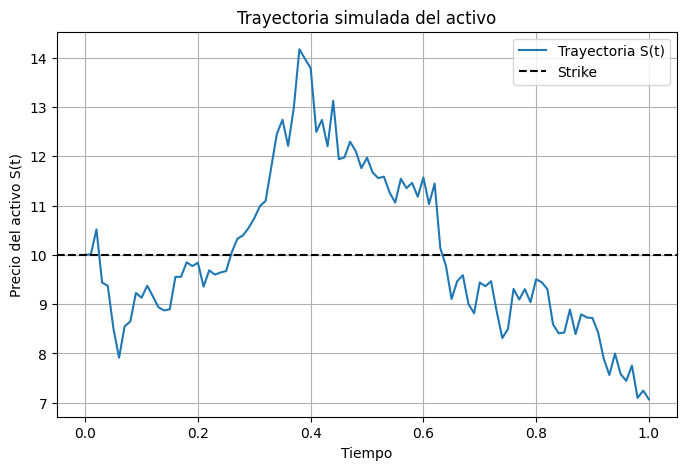

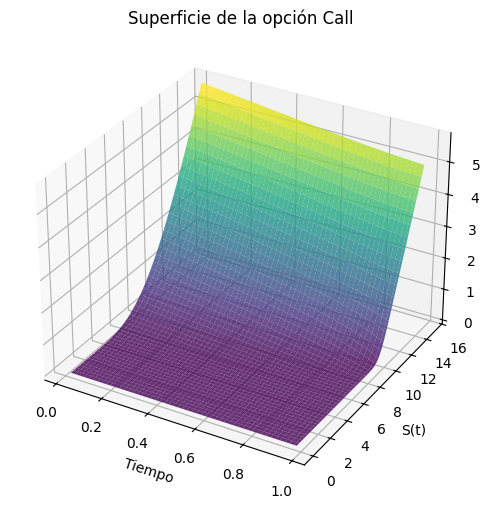

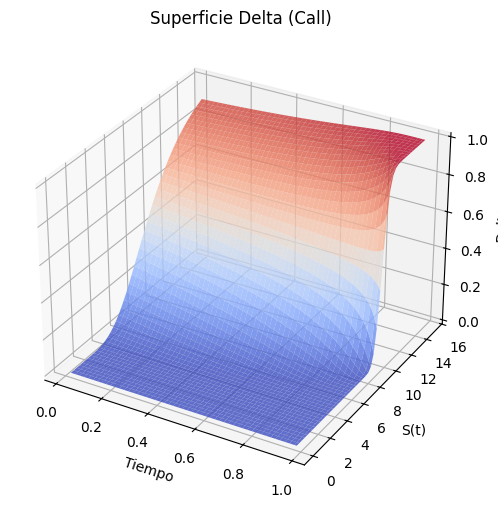

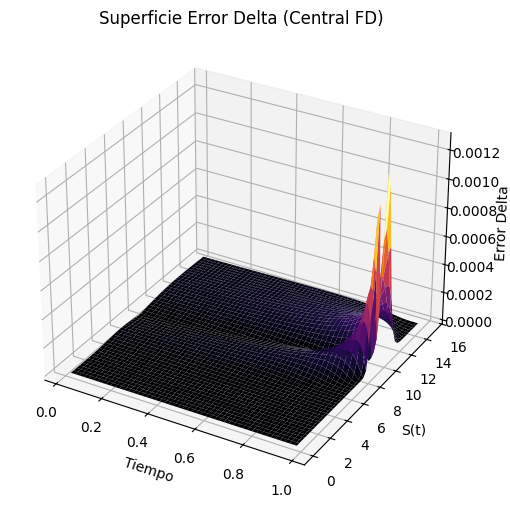

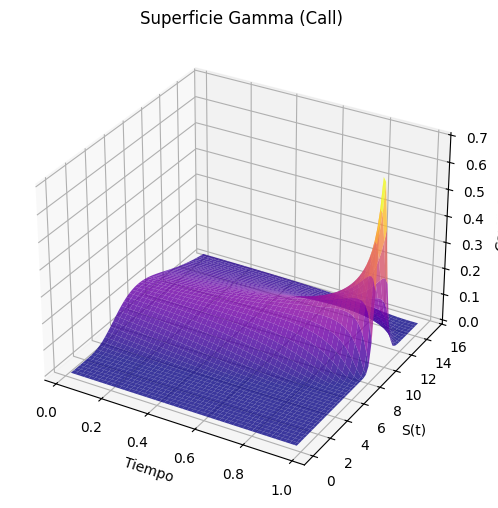

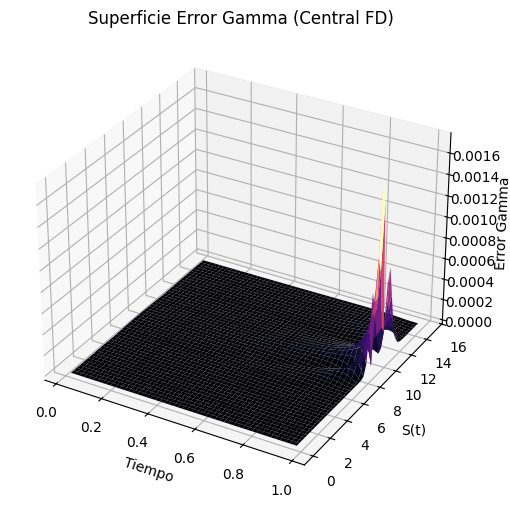

In [36]:
mainCalculation()

#### Interpretación de las gráficas
##### Primera gráfica: Superficie del precio de la opción Call

El eje X representa el tiempo hasta el vencimiento (desde 0 hasta casi 1 año).\
El eje Y es el precio del activo subyacente S(t).\
El eje Z es el valor de la opción call.

- Cuando el precio del activo S(t) es bajo (mucho menor que el strike), el valor de la opción es cercano a cero — esto es porque no tiene valor ejercerla (la opción está "out of the money").

- Cuando S(t) va aumentando y se acerca o supera el strike, el valor de la opción crece.

A medida que el tiempo avanza hacia el vencimiento (tiempo se acerca a 1), el valor de la opción cambia:

- Para precios muy altos, la opción vale casi como el activo menos el strike descontado.
- Para precios bajos, el valor permanece bajo porque la opción es menos probable que termine en dinero.

Esta superficie representa cómo varía el valor de la opción call con el tiempo y el precio del activo.

##### Segunda gráfica: Superficie del Delta (Call)
El eje X es el tiempo.\
El eje Y es nuevamente el precio del activo S(t).\
El eje Z es el Delta de la opción, que mide la sensibilidad del precio de la opción respecto al precio del activo  (es decir, cuánto cambia el valor de la opción si cambia S).

- Para precios muy bajos de S(t), el delta está cerca de 0, lo que significa que el valor de la opción no cambia mucho si sube o baja el precio del activo (porque está muy "out of the money").

- Para precios muy altos, el delta se acerca a 1, lo que indica que la opción se mueve casi 1 a 1 con el precio del activo (está "deep in the money").

- Cerca del precio de ejercicio (strike), el delta cambia rápidamente entre 0 y 1 — es la zona donde la opción es más sensible a cambios en el precio del activo.

El delta es más suave y estable a medida que se acerca el vencimiento (tiempo cercano a 1).


##### Tercera gráfica: Superficie del Gamma (Call)
El eje X es el tiempo.\
El eje Y es el precio del activo S(t).\
El eje Z es la Gamma de la opción, que mide cómo cambia Delta cuando cambia el precio del activo. Es decir, indica la curvatura del valor de la opción.

- Se aprecia un pico muy alto cuando el tiempo se acerca a 1 (vencimiento). Lo que quiere decir que cuanto más cerca está la opción del vencimiento,
más sensible es la Delta ante pequeños cambios en el precio.

- El pico ocurre alrededor de un valor concreto de S(t) (aprox. 10 en la gráfica). Eso indica que el strike está aproximadamente ahí.\

  Gamma es máxima cuando la opción está at-the-money (ATM). Es baja cuando está muy ITM o muy OTM. Cuando la opción está ATM, pequeños cambios en el precio cambian mucho la probabilidad de acabar ITM.

- Lejos del strike la Gamma es casi cero. Para valores muy bajos o muy altos de S(t): La superficie es casi plana, gamma es pequeña.

    Si la opción está claramente ITM o claramente OTM, la Delta ya está cerca de 0 o 1, y apenas cambia.


##### Gráficas del error
- Las derivadas explotan cerca de: ATM (S ~K) y cuando τ → 0
- El pico de gamma es más pronunciado que el de delta aunque más o menos tienen la misma geografía.
- Cerca del vencimiento: La opción se parece cada vez más al payoff, el payoff tiene una punta en el strike, derivar esa punta produce explosiones numéricas. (con punta me refiero a qe visualmente es como puntiagudo lo que nos viene a ddecir que es continua pero no derivable)
- El pico de Gamma es más vertical, entonces la región inestable es más estrecha. Eso es típico de derivadas de orden alto.